# Figure 4: KDE Analysis

This notebook generates Figure 4 showing KDE (Kernel Density Estimation) analysis of the UMAP space.

The figure shows:
1. Point density plot showing KDE of UMAP coordinates
2. Average values per grid cell
3. Average SFHs per grid cell with annotations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
import pickle
from scipy.stats import gaussian_kde
import cmasher as cmr

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, colors, times, boxing)
from utils.plotting import draw_grid_C, plot_points, plot_averages

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data and Reconstruct UMAP Structure

In [2]:
# Load UMAP embeddings and SFH data
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')
combined_labels = np.load('../data/combined_labels.npy')

print(f"Loaded data shapes:")
print(f"  UMAP embedding: {embedding.shape}")
print(f"  Combined SFH: {combined_sfh.shape}")
print(f"  Combined labels: {combined_labels.shape}")

# Create result array with UMAP coordinates and labels (matching original structure)
result = np.column_stack((embedding, combined_labels))

# Use combined_sfh as the sfh variable (matching original)
sfh = combined_sfh

print(f"\nPrepared data:")
print(f"  Result array: {result.shape}")
print(f"  SFH array: {sfh.shape}")

Loaded data shapes:
  UMAP embedding: (63083, 2)
  Combined SFH: (63083, 136)
  Combined labels: (63083,)

Prepared data:
  Result array: (63083, 3)
  SFH array: (63083, 136)


## Create "Battleship Grid" Structure

Convert UMAP space into 10x10 grid and calculate average SFHs per cell.

In [3]:
# Create battleship grid structure - divide UMAP space into 10x10 grid
umaps = boxing(result[:,0], result[:,1], result)

print("Created battleship grid (10x10):")
for i in range(10):
    for j in range(10):
        if umaps[i,j].shape[0] > 0:
            print(f"  Cell ({i},{j}): {umaps[i,j].shape[0]} galaxies")
        if j == 2:  # Limit output for brevity
            print("  ...")
            break
    if i == 2:  # Limit output for brevity
        print("  ...")
        break

# Calculate average SFH percentiles per grid cell
avg_sfh = boxing(x=embedding[:,0], y=embedding[:,1], z=sfh, q=[16,50,84])

print(f"\nCalculated average SFHs per cell: {type(avg_sfh)} with shape {avg_sfh.shape}")
print(f"Each cell contains percentiles [16,50,84] for {sfh.shape[1]} time bins")

Created battleship grid (10x10):
  ...
  Cell (1,1): 2 galaxies
  Cell (1,2): 195 galaxies
  ...
  Cell (2,1): 203 galaxies
  Cell (2,2): 688 galaxies
  ...
  ...

Calculated average SFHs per cell: <class 'numpy.ndarray'> with shape (10, 10, 3, 136)
Each cell contains percentiles [16,50,84] for 136 time bins


## Calculate KDE

Compute Kernel Density Estimation over the UMAP space and prepare for plotting.

In [4]:
# Calculate KDE over UMAP coordinates
kde = gaussian_kde(np.array([embedding[:,0], embedding[:,1]]))

# Evaluate KDE over 100x100 meshgrid (over full plotting space)
xx, yy = np.mgrid[0:10:100j, 0:10:100j]
pos = np.vstack([xx.ravel(), yy.ravel()])
zz = kde.evaluate(pos).reshape(xx.shape)

# Clean data
zz = zz/np.sum(zz) * 1e4  # normalize to integrate to 100x100
for i in range(10):
    for j in range(10):
        if umaps[i,j].shape[0] < 100:
            zz[i*10:i*10+10,j*10:j*10+10] = np.full((10,10), np.nan)  # get rid of boxes with too few points

# Average KDE per grid cell
kde_avg = boxing(x=xx, y=yy, z=zz, average=True)

print(f"KDE calculation completed:")
print(f"  KDE grid shape: {zz.shape}")
print(f"  KDE range: [{np.nanmin(zz):.3f}, {np.nanmax(zz):.3f}]")
print(f"  Average KDE per cell: {type(kde_avg)} (10x10 grid)")

KDE calculation completed:
  KDE grid shape: (100, 100)
  KDE range: [0.000, 4.570]
  Average KDE per cell: <class 'numpy.ndarray'> (10x10 grid)


d:\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:93: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)


## Generate Figure 4: KDE Analysis

Create three-panel figure showing KDE point density, averages, and SFHs with annotations.

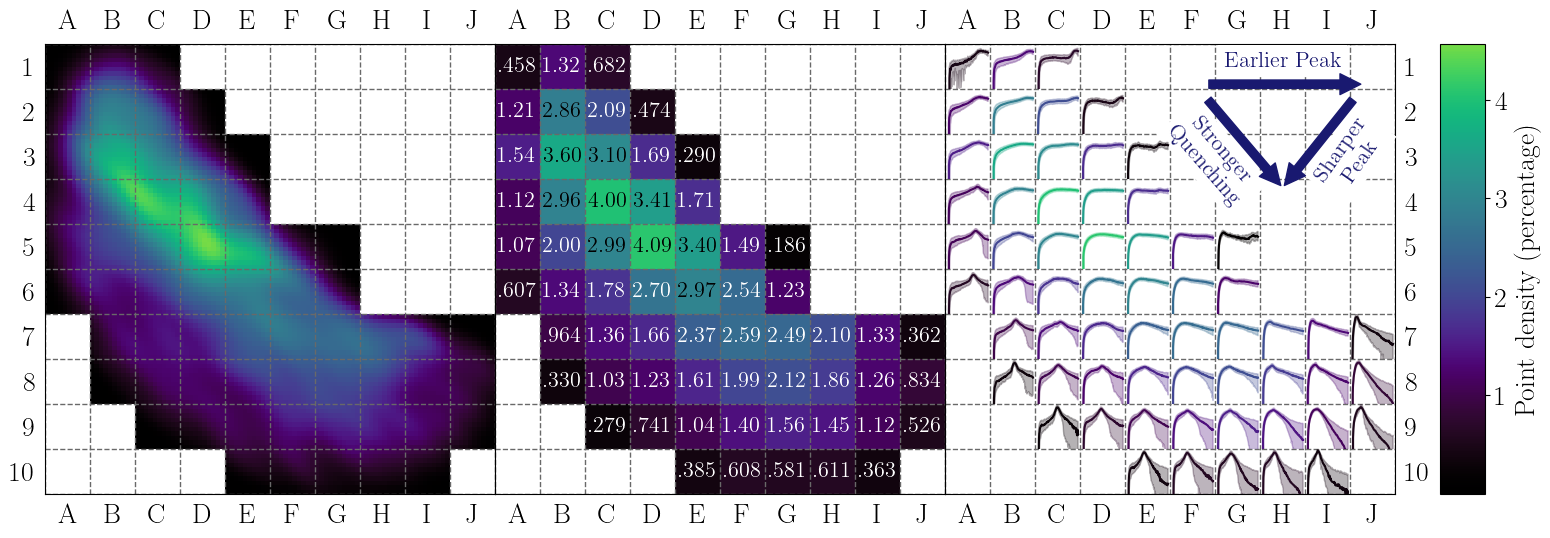

Figure 4 (KDE analysis) generated successfully!


In [5]:
# Set up the figure using draw_grid_C
cmap = cmr.lavender
fig, ax, norm = draw_grid_C(cmap, np.nanmin(zz), np.nanmax(zz))

# Plot point density using imshow
plot_points(x=zz, fig=fig, ax=ax[0], cax=ax[-1], cmap=cmap, norm=norm, 
           label="Point density (percentage)", imshow=True)

# Plot averages and SFHs
plot_averages(kde_avg, avg_sfh, fig, ax[1], ax[2], umaps, cmap, norm)

# Add axes annotations
an1 = ax[2].annotate("",
          xy=(0.93, 0.91), xycoords='axes fraction',
          xytext=(0.58, 0.91), textcoords='axes fraction',
          size=30, va="center", ha="center",
          arrowprops=dict(arrowstyle="simple", color='midnightblue'), zorder=30)
ax[2].text(7.5, 9.4, 'Earlier Peak', ha='center', va='bottom', fontsize=16,
          color='midnightblue', bbox=dict(facecolor='white', edgecolor=None, linewidth=0))

an2 = ax[2].annotate("",
          xy=(0.75, 0.68), xycoords='axes fraction',
          xytext=(0.58, 0.88), textcoords='axes fraction',
          size=30, va="center", ha="center",
          arrowprops=dict(arrowstyle="simple", color='midnightblue'), zorder=30)
ax[2].text(5.95, 6.3, 'Stronger\nQuenching', ha='center', va='bottom', fontsize=16,
          color='midnightblue', rotation=-49, bbox=dict(facecolor='white', edgecolor='white', linewidth=0))

an3 = ax[2].annotate("",
          xy=(0.75, 0.68), xycoords='axes fraction',
          xytext=(0.91, 0.88), textcoords='axes fraction',
          size=30, va="center", ha="center",
          arrowprops=dict(arrowstyle="simple", color='midnightblue'), zorder=30)
ax[2].text(9., 7.5, 'Sharper\nPeak', ha='center', va='center', fontsize=16,
          color='midnightblue', rotation=55, bbox=dict(facecolor='white', edgecolor=None, linewidth=0), zorder=20)

# Save figure
plt.savefig('../figures/umap_kde.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/umap_kde.pdf', bbox_inches='tight')

plt.show()

print("Figure 4 (KDE analysis) generated successfully!")

In [6]:
print("\nFigures saved to:")
print("- ../figures/umap_kde.png")
print("- ../figures/umap_kde.pdf")
print("\nFigure 4 shows KDE analysis of UMAP space with:")
print("- Point density from gaussian KDE")
print("- Average density per grid cell")
print("- Average SFHs per cell with interpretive annotations")
print("- Annotations indicating SFH trends across UMAP space")


Figures saved to:
- ../figures/umap_kde.png
- ../figures/umap_kde.pdf

Figure 4 shows KDE analysis of UMAP space with:
- Point density from gaussian KDE
- Average density per grid cell
- Average SFHs per cell with interpretive annotations
- Annotations indicating SFH trends across UMAP space
